In [1]:
# General imports
import numpy as np
import qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import DensityMatrix, partial_trace
# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
# [Reference]: https://docs.quantum.ibm.com/guides/build-noise-models
# https://docs.quantum.ibm.com/guides/simulate-with-qiskit-aer

from qiskit_aer import AerSimulator

from qiskit_aer.primitives import SamplerV2 as Sampler
#from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import StatevectorSampler
# sampler = StatevectorSampler()
sampler = Sampler()


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import (NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# YOUR_API_TOKEN = "a44932650c6324c729fbd156e2808cff2dc96cc78fdaf3058a5e3583edfadad4acf73471140788f0efa7ed71a98f1e13069af52fe115e4e0e2bb868ab0be5d70"
# QiskitRuntimeService.save_account(channel="ibm_quantum", token= YOUR_API_TOKEN, overwrite = True)
# service = QiskitRuntimeService()
# backend = service.backend("ibm_brisbane")
# noise_model = NoiseModel.from_backend(backend)

In [3]:
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix, kron
from numpy import trace

In [4]:
# VQA circuit.
from qiskit import QuantumCircuit, transpile

# Pauli matrices and identity (sparse format)
I = csr_matrix([[1, 0], [0, 1]], dtype=complex)
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=complex)
sigma_y = csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=complex)

"""
The TFIM for L = 2 is given by: H = J * (Z_1 * Z_2) + h * (X_1 + X_2). We will consider
the two jump operators: L_1 = sqrt(g_1) * (X_1 - i * Y_1} and L_2 = sqrt(g_2) * (X_2 - i Y_2).

"""

# The variational circuit is just the trotter circuit for the TFIM.
n_qubits = 3
def anstaz_circuit(angles_lst, number_of_layers):  

     number_of_angles_per_layer = 8

     if len(angles_lst*number_of_angles_per_layer) % number_of_layers != 0:
         raise ValueError("The number of angles should be divisible by the number of layers.")
     else:
           anstaz_circuit = QuantumCircuit(n_qubits+1)
           for i in range(number_of_layers):
               # Hamiltonian part.
               # Z_1 Z_2.
               anstaz_circuit.cx(1,2)
               anstaz_circuit.rz(angles_lst[i][0], 2)
               anstaz_circuit.cx(1,2)
               # X_1 X_2.
               anstaz_circuit.h(1)
               anstaz_circuit.h(2)
               anstaz_circuit.cx(1,2)
               anstaz_circuit.rz(angles_lst[i][1], 2)
               anstaz_circuit.cx(1,2)
               anstaz_circuit.h(1)
               anstaz_circuit.h(2)
               # Y_1 Y_2.
               anstaz_circuit.sdg(1)
               anstaz_circuit.h(1)
               anstaz_circuit.sdg(2)
               anstaz_circuit.h(2)
               anstaz_circuit.cx(1,2)
               anstaz_circuit.rz(angles_lst[i][2], 2)
               anstaz_circuit.cx(1,2)
               anstaz_circuit.h(1)
               anstaz_circuit.h(2)
               anstaz_circuit.sdg(1)
               anstaz_circuit.sdg(2)

               # Z_2 Z_3.
               anstaz_circuit.cx(2,3)
               anstaz_circuit.rz(angles_lst[i][3], 3)
               anstaz_circuit.cx(2,3)
               # X_2 X_3
               anstaz_circuit.h(2)
               anstaz_circuit.h(3)
               anstaz_circuit.cx(2,3)
               anstaz_circuit.rz(angles_lst[i][4], 3)
               anstaz_circuit.cx(2,3)
               anstaz_circuit.h(2)
               anstaz_circuit.h(3)
               # Y_2 Y_3.
               anstaz_circuit.sdg(2)
               anstaz_circuit.h(2)
               anstaz_circuit.sdg(3)
               anstaz_circuit.h(3)
               anstaz_circuit.cx(2,3)
               anstaz_circuit.rz(angles_lst[i][5], 3)
               anstaz_circuit.cx(2,3)
               anstaz_circuit.h(2)
               anstaz_circuit.h(3)
               anstaz_circuit.sdg(2)
               anstaz_circuit.sdg(3)

               # Jump operator part.
               anstaz_circuit.cry(angles_lst[i][6], 1, 0)
               anstaz_circuit.cx(0,1)
               anstaz_circuit.reset(0)
               anstaz_circuit.x(1)
               anstaz_circuit.cry(angles_lst[i][7], 1, 0)
               anstaz_circuit.cx(0,1)
               anstaz_circuit.x(1)
               anstaz_circuit.reset(0)

     return anstaz_circuit      

#anstaz_circuit([[np.random.uniform(0, 2*np.pi) for i in range(8)] for j in range(1)], 1).draw("mpl", scale = 1.5)     

In [5]:
J = 1.0
h = 0.5
gamma_1 = 1
gamma_2 = 0.5

# Hilbert space dimension for L = 3
dim = 2**3  # 2^L where L = 3

# Hamiltonian of the Heisenberg model with L = 3
def build_hamiltonian():
    H = J * (
        kron(kron(sigma_x, sigma_x), I)
        + kron(kron(sigma_y, sigma_y), I)
        + kron(kron(sigma_z, sigma_z), I)
        + kron(kron(I, sigma_x), sigma_x)
        + kron(kron(I, sigma_y), sigma_y)
        + kron(kron(I, sigma_z), sigma_z)
    )
    H += h * (
        kron(kron(sigma_x, I), I)
        + kron(kron(I, sigma_x), I)
        + kron(kron(I, I), sigma_x)
    )
    return H

# Jump operators
def build_jump_operators():
    L_1 = np.sqrt(gamma_1) * (kron(kron(sigma_x, I), I) - 1j * kron(kron(sigma_y, I), I))
    L_2 = np.sqrt(gamma_2) * (kron(kron(sigma_x, I), I) + 1j * kron(kron(sigma_y, I), I))
    return L_1, L_2

# Lindblad equation
def lindblad_equation(rho):
    # Ensure rho is an (8x8) matrix
    rho = csr_matrix(rho)

    # Build Hamiltonian and jump operators
    H = build_hamiltonian()
    L_1, L_2 = build_jump_operators()

    # Commutator: -i [H, rho]
    commutator = -1j * (H @ rho - rho @ H)

    # Lindblad dissipator terms
    lindblad_1 = L_1 @ rho @ L_1.getH() - 0.5 * (L_1.getH() @ L_1 @ rho + rho @ L_1.getH() @ L_1)
    lindblad_2 = L_2 @ rho @ L_2.getH() - 0.5 * (L_2.getH() @ L_2 @ rho + rho @ L_2.getH() @ L_2)

    d_rho_dt = commutator + lindblad_1 + lindblad_2
    return d_rho_dt

# Cost function
def cost_function(rho):
    L_rho = lindblad_equation(rho)
    return np.real(np.trace(L_rho.conj().T @ L_rho.toarray()))

In [6]:
def return_density_matrix(quantum_circuit):

     quantum_circuit.save_density_matrix()  # Save the density matrix

     # Step 2: Simulate the circuit
     simulator = AerSimulator()  # Aer simulator supports reset gates
     quantum_circuit = transpile(quantum_circuit, simulator)
     result = simulator.run(quantum_circuit).result()
     # Step 3: Extract the density matrix
     rho_full = DensityMatrix(result.data()["density_matrix"])

     # Step 4: Compute the reduced density matrix for the second qubit
     rho_1 = partial_trace(rho_full, [0])  # Trace out qubit 0
     rho_1_matrix = rho_1.data

     return rho_1_matrix

In [7]:
import numpy as np

def update_angles(current_angles_lst, number_of_layers, learning_rate):
    """
    Perform parameter-shift updates on angles for a VQA circuit.
    
    Parameters:
        current_angles_lst (list of lists): Current angles for each layer (shape: [number_of_layers, 8]).
        number_of_layers (int): Number of layers in the VQA circuit.
        learning_rate (float): Learning rate for gradient descent.

    Returns:
        updated_angles (list of lists): Updated angles after applying parameter-shift rule.
    """
    # Initialize the updated angles as a copy of the current angles
    updated_angles = np.array(current_angles_lst, copy=True)
    
    # Iterate over each layer and each parameter
    for i in range(number_of_layers):
        for j in range(8):  # Assuming 8 parameters per layer
            # Create shifted angle sets for parameter (i, j)
            angles_plus = np.array(current_angles_lst, copy=True)
            angles_minus = np.array(current_angles_lst, copy=True)
            
            # Shift the specific parameter
            angles_plus[i][j] += np.pi / 2
            angles_minus[i][j] -= np.pi / 2
            
            # Compute the cost for shifted parameters
            cost_plus = cost_function(return_density_matrix(anstaz_circuit(angles_plus, number_of_layers)))
            cost_minus = cost_function(return_density_matrix(anstaz_circuit(angles_minus, number_of_layers)))
            
            # Compute the gradient for this parameter
            gradient = (cost_plus - cost_minus) / 2
            
            # Update the parameter using gradient descent
            updated_angles[i][j] -= learning_rate * gradient
    
    return updated_angles

In [8]:
import numpy as np

# Parameters
initial_learning_rate = 0.01
number_of_layers = 4
max_iterations = 100
tolerance_for_convergence = 1e-2

# Random seed for reproducibility
np.random.seed(1000)

# Initialize angles randomly within [-π, π]
initial_angles_lst = [[np.random.uniform(-np.pi, np.pi) for _ in range(8)] for _ in range(number_of_layers)]
angles_lst = initial_angles_lst.copy()
best_angles_lst = initial_angles_lst.copy()

# Initialize optimization variables
number_of_iteration = 0
best_cost = float("inf")
best_iteration = 0
cost_function_values_lst = []

# Print initial state
print("Initial angles: ", initial_angles_lst)

# Optimization loop
while number_of_iteration < max_iterations:
    # Generate variational circuit and compute cost
    vqa_circuit = anstaz_circuit(angles_lst, number_of_layers)
    rho = return_density_matrix(vqa_circuit)
    cost_value = cost_function(rho)

    # Record and display the cost
    cost_function_values_lst.append(cost_value)
    print(f"Iteration {number_of_iteration}: Cost value = {cost_value:.6f}")

    # Update best solution
    if cost_value < best_cost:
        best_cost = cost_value
        best_angles_lst = angles_lst.copy()
        best_iteration = number_of_iteration

    # Check for convergence
    if cost_value < tolerance_for_convergence:
        print("Optimization has converged.")
        print(f"Best cost value: {best_cost:.6f}")
        print("Best angles:", best_angles_lst)
        break

    # Adjust learning rate
    learning_rate = initial_learning_rate / (number_of_iteration + 1)

    # Update angles using the parameter-shift rule
    angles_lst = update_angles(angles_lst, number_of_layers, learning_rate)

    # Increment iteration counter
    number_of_iteration += 1

# Post-optimization summary
if number_of_iteration == max_iterations:
    print("The optimization did not converge within the maximum iterations.")
print(f"Best cost value: {best_cost:.6f}")
print("Best angles:", best_angles_lst)

# Save cost function values for later analysis
np.save("cost_function_values_noisy.npy", cost_function_values_lst)

Initial angles:  [[0.9650318267270377, -2.4189827183268884, 2.8292106773525294, -0.11189472488906116, 2.3403265267543105, -1.8074670725821078, -2.885806537379858, -0.6459462499693442], [-1.6767798565799603, 2.1472202974917467, -1.840455909962682, 1.5234810108436774, -0.6776155995914559, -1.9964411652872887, 1.530203271484452, -2.7043955447963945], [2.4211450608747898, 2.844048638565922, 2.708954094052678, -0.5313629932704154, -2.9594955171525203, 3.0286680088841296, -1.0075861500080392, 1.2986539398243107], [-0.8678519793927273, -2.921015791386453, 2.23089679995298, 0.9880529318507874, 1.6693354851808433, 0.3398401391351351, 2.4196102812103595, 2.539648518261732]]
Iteration 0: Cost value = 2.247687
Iteration 1: Cost value = 2.232352
Iteration 2: Cost value = 2.084923
Iteration 3: Cost value = 1.962112
Iteration 4: Cost value = 2.236006
Iteration 5: Cost value = 1.941429
Iteration 6: Cost value = 2.027711
Iteration 7: Cost value = 2.111331
Iteration 8: Cost value = 2.077080
Iteration 9:

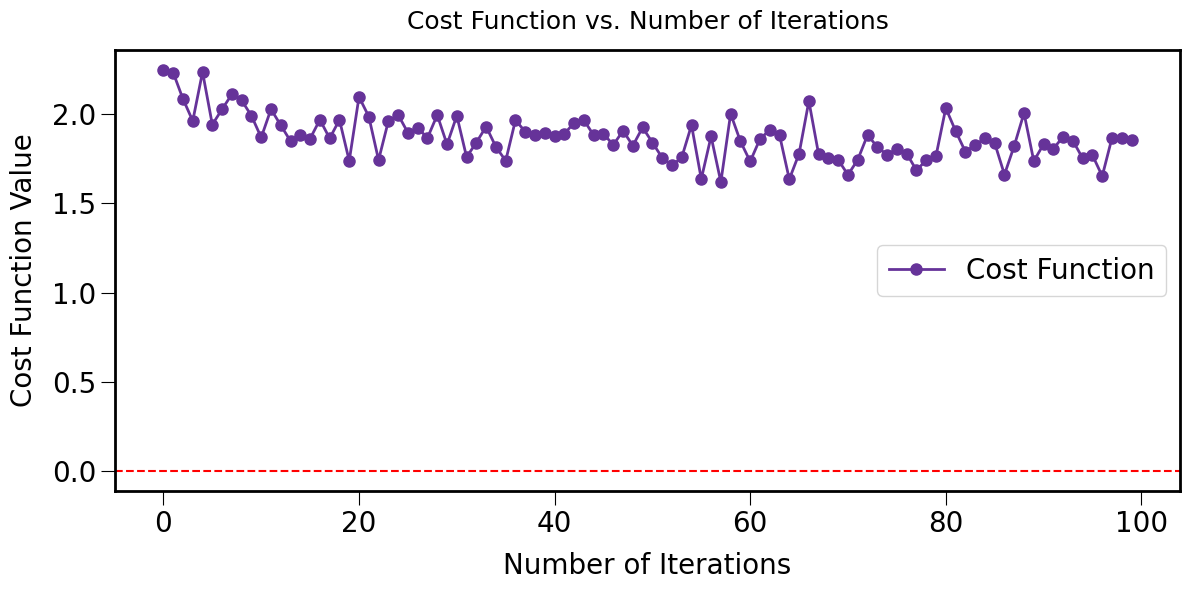

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(cost_function_values_lst)), cost_function_values_lst, marker="o", linestyle='-', color="rebeccapurple", linewidth=2, markersize=8, label="Cost Function")
plt.xlabel("Number of Iterations", fontsize=20, labelpad=10)
plt.ylabel("Cost Function Value", fontsize=20, labelpad=10)
plt.title("Cost Function vs. Number of Iterations", fontsize=18, pad=15)
#plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color="r", linestyle="--")
# Get current axis
ax = plt.gca()
# Make axis lines thicker
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
# Make ticks longer
ax.tick_params(axis='both', which='major', length=10)
plt.tight_layout()
#plt.axhline(y=0.8, color="r", linestyle="--")
plt.show()